# import

In [1]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F

In [2]:
image_dir = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/ECSSD_Dataset/Images"
mask_dir = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/ECSSD_Dataset/Masks"

In [3]:


# Custom Dataset Class with Augmentation
class ECSSDDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, train=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.train = train
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

        # Verify matching pairs
        assert len(self.image_files) == len(self.mask_files)
        for img, mask in zip(self.image_files, self.mask_files):
            assert os.path.splitext(img)[0] == os.path.splitext(mask)[0]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Convert to grayscale

        if self.transform:
            seed = torch.random.seed()

            # Apply same transform to both image and mask
            torch.random.manual_seed(seed)
            image = self.transform(image)

            torch.random.manual_seed(seed)
            mask = self.transform(mask)

        return image, mask

In [4]:
# Define transformations with augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

# Simpler transform for validation
val_transform = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = ECSSDDataset(image_dir, mask_dir, transform=train_transform, train=True)
test_dataset = ECSSDDataset(image_dir, mask_dir, transform=val_transform, train=False)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class REBNCONV(nn.Module):
    def __init__(self,in_ch=3,out_ch=3,dirate=1):
        super(REBNCONV,self).__init__()

        self.conv_s1 = nn.Conv2d(in_ch,out_ch,3,padding=1*dirate,dilation=1*dirate)
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self,x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout

## upsample tensor 'src' to have the same spatial size with tensor 'tar'
def _upsample_like(src,tar):

    src = F.upsample(src,size=tar.shape[2:],mode='bilinear')

    return src


### RSU-7 ###
class RSU7(nn.Module):#UNet07DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool5 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)

        hx6 = self.rebnconv6(hx)

        hx7 = self.rebnconv7(hx6)

        hx6d =  self.rebnconv6d(torch.cat((hx7,hx6),1))
        hx6dup = _upsample_like(hx6d,hx5)

        hx5d =  self.rebnconv5d(torch.cat((hx6dup,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-6 ###
class RSU6(nn.Module):#UNet06DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)


        hx5d =  self.rebnconv5d(torch.cat((hx6,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-5 ###
class RSU5(nn.Module):#UNet05DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)

        hx5 = self.rebnconv5(hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4 ###
class RSU4(nn.Module):#UNet04DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4F ###
class RSU4F(nn.Module):#UNet04FRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx2d = self.rebnconv2d(torch.cat((hx3d,hx2),1))
        hx1d = self.rebnconv1d(torch.cat((hx2d,hx1),1))

        return hx1d + hxin


##### U^2-Net ####
class U2NET(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super(U2NET,self).__init__()

        self.stage1 = RSU7(in_ch,32,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,32,128)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(128,64,256)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(256,128,512)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(512,256,512)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(512,256,512)

        # decoder
        self.stage5d = RSU4F(1024,256,512)
        self.stage4d = RSU4(1024,128,256)
        self.stage3d = RSU5(512,64,128)
        self.stage2d = RSU6(256,32,64)
        self.stage1d = RSU7(128,16,64)

        self.side1 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(128,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(256,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(512,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(512,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(6*out_ch,out_ch,1)

    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6,hx5)

        #-------------------- decoder --------------------
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))

        return F.sigmoid(d0), F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)

### U^2-Net small ###
class U2NETP(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super(U2NETP,self).__init__()

        self.stage1 = RSU7(in_ch,16,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,16,64)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(64,16,64)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(64,16,64)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(64,16,64)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(64,16,64)

        # decoder
        self.stage5d = RSU4F(128,16,64)
        self.stage4d = RSU4(128,16,64)
        self.stage3d = RSU5(128,16,64)
        self.stage2d = RSU6(128,16,64)
        self.stage1d = RSU7(128,16,64)

        self.side1 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(64,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(6*out_ch,out_ch,1)

    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6,hx5)

        #decoder
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))

        return F.sigmoid(d0), F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)

In [6]:
# Define hybrid loss function
class HybridLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super(HybridLoss, self).__init__()
        self.alpha = alpha  # Weight for BCE
        self.beta = beta    # Weight for Dice

    def forward(self, pred, target):
        # Binary Cross Entropy
        bce = F.binary_cross_entropy(pred, target)

        # Dice Loss
        smooth = 1e-8
        intersection = (pred * target).sum()
        dice = 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

        # IoU (for monitoring)
        union = pred.sum() + target.sum() - intersection
        iou = (intersection + smooth) / (union + smooth)

        return self.alpha * bce + self.beta * dice, iou.item()

In [7]:
# Initialize model, loss, optimizer and scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = U2NET(in_ch=3, out_ch=1).to(device)

In [8]:
# Initialize weights
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

model.apply(init_weights)

criterion = HybridLoss(alpha=0.7, beta=0.3)  # More weight to BCE
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Train

In [ ]:
# Enhanced training function
def train(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=100,
          model_path='/content/drive/MyDrive/Colab Notebooks/Computer Vision/U2-net/best_u2net_again.pth'):

    best_iou = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_iou': []}

    # Check for existing model
    if os.path.exists(model_path):
        try:
            checkpoint = torch.load(model_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            best_iou = checkpoint['best_iou']
            start_epoch = checkpoint['epoch'] + 1
            print(f"Loaded checkpoint from epoch {start_epoch} with best IoU: {best_iou:.4f}")
        except:
            start_epoch = 0
            print("Failed to load checkpoint, starting from scratch")
    else:
        start_epoch = 0

    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss = 0.0

        # Training phase
        for images, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            # Forward pass
            d0, d1, d2, d3, d4, d5, d6 = model(images)

            # Calculate hybrid loss (main output d0)
            loss, _ = criterion(d0, masks)

            # Backward pass with gradient clipping
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        with torch.no_grad():
            for images, masks in test_loader:
                images, masks = images.to(device), masks.to(device)
                d0, _, _, _, _, _, _ = model(images)
                loss, iou = criterion(d0, masks)
                val_loss += loss.item()
                val_iou += iou

        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(test_loader)
        val_iou /= len(test_loader)

        # Update learning rate
        scheduler.step(val_loss)

        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)

        # Print metrics
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}')
        print(f'Current LR: {optimizer.param_groups[0]["lr"]:.2e}')

        # Save best model
        if val_iou > best_iou:
            best_iou = val_iou
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_iou': best_iou,
                'history': history,
            }, model_path)
            print(f'Saved new best model with IoU: {best_iou:.4f}')

    return model, history


In [ ]:
# Start training
trained_model, history = train(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=50
)

Epoch 1/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 1/50:   1%|          | 1/125 [00:26<54:51, 26.54s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.f


Epoch 1/50:
Train Loss: 13.0811 | Val Loss: 12.1094 | Val IoU: 0.4476
Current LR: 1.00e-04
Saved new best model with IoU: 0.4476


Epoch 2/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 2/50:   1%|          | 1/125 [00:01<03:25,  1.66s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 2/50:   2%|▏         | 3/125 [00:03<02:03,  1.01s


Epoch 2/50:
Train Loss: 11.7361 | Val Loss: 10.6377 | Val IoU: 0.4191
Current LR: 1.00e-04


Epoch 3/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 3/50:   1%|          | 1/125 [00:01<02:44,  1.33s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 3/50:   2%|▏         | 2/125 [00:02<02:08,  1.04s


Epoch 3/50:
Train Loss: 10.6970 | Val Loss: 9.4302 | Val IoU: 0.4917
Current LR: 1.00e-04
Saved new best model with IoU: 0.4917


Epoch 4/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 4/50:   1%|          | 1/125 [00:01<02:39,  1.28s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 4/50:   2%|▏         | 2/125 [00:02<02:04,  1.02s


Epoch 4/50:
Train Loss: 6.4013 | Val Loss: 3.7841 | Val IoU: 0.4324
Current LR: 1.00e-04


Epoch 5/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 5/50:   1%|          | 1/125 [00:01<02:51,  1.39s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 5/50:   2%|▏         | 3/125 [00:03<01:56,  1.05i


Epoch 5/50:
Train Loss: 2.2709 | Val Loss: 1.5114 | Val IoU: 0.3851
Current LR: 1.00e-04


Epoch 6/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 6/50:   1%|          | 1/125 [00:01<02:53,  1.40s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 6/50:   2%|▏         | 3/125 [00:03<01:57,  1.04i


Epoch 6/50:
Train Loss: 1.4501 | Val Loss: 1.5146 | Val IoU: 0.4117
Current LR: 1.00e-04


Epoch 7/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 7/50:   1%|          | 1/125 [00:01<03:00,  1.45s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 7/50:   2%|▏         | 2/125 [00:02<02:13,  1.09s


Epoch 7/50:
Train Loss: 0.9634 | Val Loss: 0.5600 | Val IoU: 0.4138
Current LR: 1.00e-04


Epoch 8/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 8/50:   1%|          | 1/125 [00:01<02:59,  1.45s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 8/50:   2%|▏         | 3/125 [00:03<01:58,  1.03i


Epoch 8/50:
Train Loss: 0.6983 | Val Loss: 0.6485 | Val IoU: 0.4091
Current LR: 1.00e-04


Epoch 9/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 9/50:   1%|          | 1/125 [00:01<02:48,  1.36s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 9/50:   2%|▏         | 2/125 [00:02<02:09,  1.05s


Epoch 9/50:
Train Loss: 0.6603 | Val Loss: 1.3736 | Val IoU: 0.3855
Current LR: 1.00e-04


Epoch 10/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 10/50:   1%|          | 1/125 [00:01<02:53,  1.40s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 10/50:   2%|▏         | 2/125 [00:02<02:11,  1.07s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bili


Epoch 10/50:
Train Loss: 0.5328 | Val Loss: 0.4356 | Val IoU: 0.4169
Current LR: 1.00e-04


Epoch 11/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 11/50:   1%|          | 1/125 [00:01<03:15,  1.58s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn


Epoch 11/50:
Train Loss: 0.5324 | Val Loss: 0.6878 | Val IoU: 0.4265
Current LR: 1.00e-04


Epoch 12/50:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 12/50:   2%|▏         | 2/125 [00:02<02:12,  1.08s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 12/50:   2%|▏         | 3/125 [00:03<01:57,  1.03it/s]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 12/50:   5%|▍         | 6/125 [00:05<01:42,  1.16it/s]/tmp/ipy


Epoch 12/50:
Train Loss: 0.5069 | Val Loss: 0.6332 | Val IoU: 0.4597
Current LR: 1.00e-04


Epoch 13/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 13/50:   1%|          | 1/125 [00:01<03:44,  1.81s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 13/50:   2%|▏         | 3/125 [00:03<02:07,  1.


Epoch 13/50:
Train Loss: 0.4971 | Val Loss: 0.3982 | Val IoU: 0.4303
Current LR: 1.00e-04


Epoch 14/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 14/50:   2%|▏         | 2/125 [00:02<02:12,  1.07s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 14/50:   2%|▏         | 3/125 [00:03<01:57,  1.


Epoch 14/50:
Train Loss: 0.4630 | Val Loss: 0.4255 | Val IoU: 0.4010
Current LR: 1.00e-04


Epoch 15/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 15/50:   1%|          | 1/125 [00:01<03:00,  1.46s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 15/50:   2%|▏         | 3/125 [00:03<01:58,  1.


Epoch 15/50:
Train Loss: 0.4504 | Val Loss: 0.3924 | Val IoU: 0.4978
Current LR: 1.00e-04
Saved new best model with IoU: 0.4978


Epoch 16/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 16/50:   2%|▏         | 2/125 [00:02<02:11,  1.07s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn


Epoch 16/50:
Train Loss: 0.4299 | Val Loss: 0.3452 | Val IoU: 0.5096
Current LR: 1.00e-04
Saved new best model with IoU: 0.5096


Epoch 17/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 17/50:   1%|          | 1/125 [00:01<02:53,  1.40s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 17/50:   2%|▏         | 2/125 [00:02<02:11,  1.


Epoch 17/50:
Train Loss: 0.4347 | Val Loss: 0.3412 | Val IoU: 0.5063
Current LR: 1.00e-04


Epoch 18/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 18/50:   2%|▏         | 2/125 [00:02<02:16,  1.11s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn


Epoch 18/50:
Train Loss: 0.4193 | Val Loss: 0.3746 | Val IoU: 0.5086
Current LR: 1.00e-04


Epoch 19/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 19/50:   2%|▏         | 2/125 [00:02<02:18,  1.12s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn


Epoch 19/50:
Train Loss: 0.3727 | Val Loss: 0.3609 | Val IoU: 0.5328
Current LR: 1.00e-04
Saved new best model with IoU: 0.5328


Epoch 20/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 20/50:   1%|          | 1/125 [00:01<03:13,  1.56s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 20/50:   2%|▏         | 2/125 [00:02<02:18,  1.


Epoch 20/50:
Train Loss: 0.3935 | Val Loss: 0.3307 | Val IoU: 0.4913
Current LR: 1.00e-04


Epoch 21/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 21/50:   1%|          | 1/125 [00:01<02:52,  1.39s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 21/50:   2%|▏         | 3/125 [00:03<01:56,  1.


Epoch 21/50:
Train Loss: 0.3790 | Val Loss: 0.2864 | Val IoU: 0.5594
Current LR: 1.00e-04
Saved new best model with IoU: 0.5594


Epoch 22/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 22/50:   1%|          | 1/125 [00:01<03:09,  1.53s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 22/50:   2%|▏         | 2/125 [00:02<02:16,  1.


Epoch 22/50:
Train Loss: 0.3611 | Val Loss: 0.2886 | Val IoU: 0.5271
Current LR: 1.00e-04


Epoch 23/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 23/50:   1%|          | 1/125 [00:01<03:40,  1.78s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 23/50:   2%|▏         | 2/125 [00:02<02:30,  1.


Epoch 23/50:
Train Loss: 0.3633 | Val Loss: 0.4088 | Val IoU: 0.5079
Current LR: 1.00e-04


Epoch 24/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 24/50:   1%|          | 1/125 [00:01<03:06,  1.51s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 24/50:   2%|▏         | 2/125 [00:02<02:16,  1.


Epoch 24/50:
Train Loss: 0.3558 | Val Loss: 0.6048 | Val IoU: 0.5677
Current LR: 1.00e-04
Saved new best model with IoU: 0.5677


Epoch 25/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 25/50:   2%|▏         | 2/125 [00:02<02:33,  1.25s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 25/50:   2%|▏         | 3/125 [00:03<02:08,  1.


Epoch 25/50:
Train Loss: 0.3481 | Val Loss: 0.2844 | Val IoU: 0.5578
Current LR: 1.00e-04


Epoch 26/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 26/50:   1%|          | 1/125 [00:01<03:55,  1.90s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 26/50:   2%|▏         | 2/125 [00:02<02:36,  1.


Epoch 26/50:
Train Loss: 0.3313 | Val Loss: 0.3642 | Val IoU: 0.5505
Current LR: 1.00e-04


Epoch 27/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 27/50:   1%|          | 1/125 [00:01<03:02,  1.47s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 27/50:   2%|▏         | 2/125 [00:02<02:15,  1.


Epoch 27/50:
Train Loss: 0.3497 | Val Loss: 0.2915 | Val IoU: 0.5853
Current LR: 1.00e-04
Saved new best model with IoU: 0.5853


Epoch 28/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 28/50:   2%|▏         | 2/125 [00:02<02:45,  1.35s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 28/50:   2%|▏         | 3/125 [00:03<02:15,  1.


Epoch 28/50:
Train Loss: 0.3411 | Val Loss: 0.2619 | Val IoU: 0.5664
Current LR: 1.00e-04


Epoch 29/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 29/50:   2%|▏         | 2/125 [00:02<02:34,  1.26s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 29/50:   2%|▏         | 3/125 [00:03<02:09,  1.


Epoch 29/50:
Train Loss: 0.3280 | Val Loss: 0.3463 | Val IoU: 0.5827
Current LR: 1.00e-04


Epoch 30/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 30/50:   2%|▏         | 2/125 [00:02<02:05,  1.02s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 30/50:   2%|▏         | 3/125 [00:02<01:53,  1.


Epoch 30/50:
Train Loss: 0.3230 | Val Loss: 0.2385 | Val IoU: 0.6014
Current LR: 1.00e-04
Saved new best model with IoU: 0.6014


Epoch 31/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 31/50:   1%|          | 1/125 [00:01<03:30,  1.70s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 31/50:   2%|▏         | 3/125 [00:03<02:06,  1.


Epoch 31/50:
Train Loss: 0.3181 | Val Loss: 0.2507 | Val IoU: 0.5995
Current LR: 1.00e-04


Epoch 32/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 32/50:   1%|          | 1/125 [00:01<02:59,  1.44s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 32/50:   2%|▏         | 3/125 [00:03<01:59,  1.


Epoch 32/50:
Train Loss: 0.3123 | Val Loss: 0.2500 | Val IoU: 0.6107
Current LR: 1.00e-04
Saved new best model with IoU: 0.6107


Epoch 33/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 33/50:   2%|▏         | 2/125 [00:02<02:15,  1.10s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 33/50:   2%|▏         | 3/125 [00:03<01:58,  1.


Epoch 33/50:
Train Loss: 0.3172 | Val Loss: 0.2465 | Val IoU: 0.6033
Current LR: 1.00e-04


Epoch 34/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 34/50:   1%|          | 1/125 [00:01<02:55,  1.42s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 34/50:   2%|▏         | 3/125 [00:03<01:57,  1.


Epoch 34/50:
Train Loss: 0.3291 | Val Loss: 0.2243 | Val IoU: 0.6266
Current LR: 1.00e-04
Saved new best model with IoU: 0.6266


Epoch 35/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 35/50:   1%|          | 1/125 [00:01<03:41,  1.78s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 35/50:   2%|▏         | 2/125 [00:02<02:30,  1.


Epoch 35/50:
Train Loss: 0.3069 | Val Loss: 0.2801 | Val IoU: 0.6184
Current LR: 1.00e-04


Epoch 36/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 36/50:   1%|          | 1/125 [00:01<03:30,  1.69s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 36/50:   2%|▏         | 2/125 [00:02<02:25,  1.


Epoch 36/50:
Train Loss: 0.3014 | Val Loss: 0.2291 | Val IoU: 0.6433
Current LR: 1.00e-04
Saved new best model with IoU: 0.6433


Epoch 37/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 37/50:   1%|          | 1/125 [00:01<03:05,  1.50s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 37/50:   2%|▏         | 2/125 [00:02<02:15,  1.


Epoch 37/50:
Train Loss: 0.3102 | Val Loss: 0.2137 | Val IoU: 0.6257
Current LR: 1.00e-04


Epoch 38/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 38/50:   1%|          | 1/125 [00:01<02:42,  1.31s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 38/50:   2%|▏         | 2/125 [00:02<02:06,  1.


Epoch 38/50:
Train Loss: 0.2957 | Val Loss: 0.2481 | Val IoU: 0.5917
Current LR: 1.00e-04


Epoch 39/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 39/50:   1%|          | 1/125 [00:01<04:01,  1.95s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 39/50:   2%|▏         | 2/125 [00:02<02:40,  1.


Epoch 39/50:
Train Loss: 0.2837 | Val Loss: 0.2162 | Val IoU: 0.6488
Current LR: 1.00e-04
Saved new best model with IoU: 0.6488


Epoch 40/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 40/50:   2%|▏         | 2/125 [00:02<02:08,  1.05s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn


Epoch 40/50:
Train Loss: 0.2965 | Val Loss: 0.2178 | Val IoU: 0.6441
Current LR: 1.00e-04


Epoch 41/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 41/50:   1%|          | 1/125 [00:01<02:58,  1.44s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 41/50:   2%|▏         | 2/125 [00:02<02:13,  1.


Epoch 41/50:
Train Loss: 0.2829 | Val Loss: 0.3159 | Val IoU: 0.6481
Current LR: 1.00e-04


Epoch 42/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 42/50:   2%|▏         | 2/125 [00:02<02:12,  1.08s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 42/50:   2%|▏         | 3/125 [00:03<01:58,  1.


Epoch 42/50:
Train Loss: 0.2699 | Val Loss: 0.2285 | Val IoU: 0.6204
Current LR: 1.00e-04


Epoch 43/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 43/50:   1%|          | 1/125 [00:01<02:51,  1.38s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 43/50:   2%|▏         | 3/125 [00:03<01:56,  1.


Epoch 43/50:
Train Loss: 0.2691 | Val Loss: 0.1850 | Val IoU: 0.6675
Current LR: 1.00e-04
Saved new best model with IoU: 0.6675


Epoch 44/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 44/50:   1%|          | 1/125 [00:01<03:11,  1.55s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 44/50:   2%|▏         | 2/125 [00:02<02:18,  1.


Epoch 44/50:
Train Loss: 0.2693 | Val Loss: 0.2133 | Val IoU: 0.6438
Current LR: 1.00e-04


Epoch 45/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 45/50:   2%|▏         | 2/125 [00:02<02:09,  1.05s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 45/50:   2%|▏         | 3/125 [00:03<01:56,  1.


Epoch 45/50:
Train Loss: 0.2620 | Val Loss: 0.1818 | Val IoU: 0.6688
Current LR: 1.00e-04
Saved new best model with IoU: 0.6688


Epoch 46/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 46/50:   1%|          | 1/125 [00:01<03:16,  1.59s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 46/50:   2%|▏         | 3/125 [00:03<02:01,  1.


Epoch 46/50:
Train Loss: 0.2653 | Val Loss: 0.2257 | Val IoU: 0.6579
Current LR: 1.00e-04


Epoch 47/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 47/50:   1%|          | 1/125 [00:01<03:01,  1.47s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 47/50:   2%|▏         | 3/125 [00:03<01:58,  1.


Epoch 47/50:
Train Loss: 0.2596 | Val Loss: 0.1565 | Val IoU: 0.7009
Current LR: 1.00e-04
Saved new best model with IoU: 0.7009


Epoch 48/50:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 48/50:   1%|          | 1/125 [00:01<03:14,  1.56s/it]/tmp/ipython-input-6-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')
Epoch 48/50:   2%|▏         | 2/125 [00:02<02:19,  1.

In [ ]:



# U2-Net model implementation (keep your existing U2NET class exactly as is)
# ... [Your existing U2NET class implementation remains unchanged] ...

# Plot training curves (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_iou'], label='Val IoU', color='green')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.show()

#Test

Model loaded successfully


/tmp/ipython-input-5-82774115.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


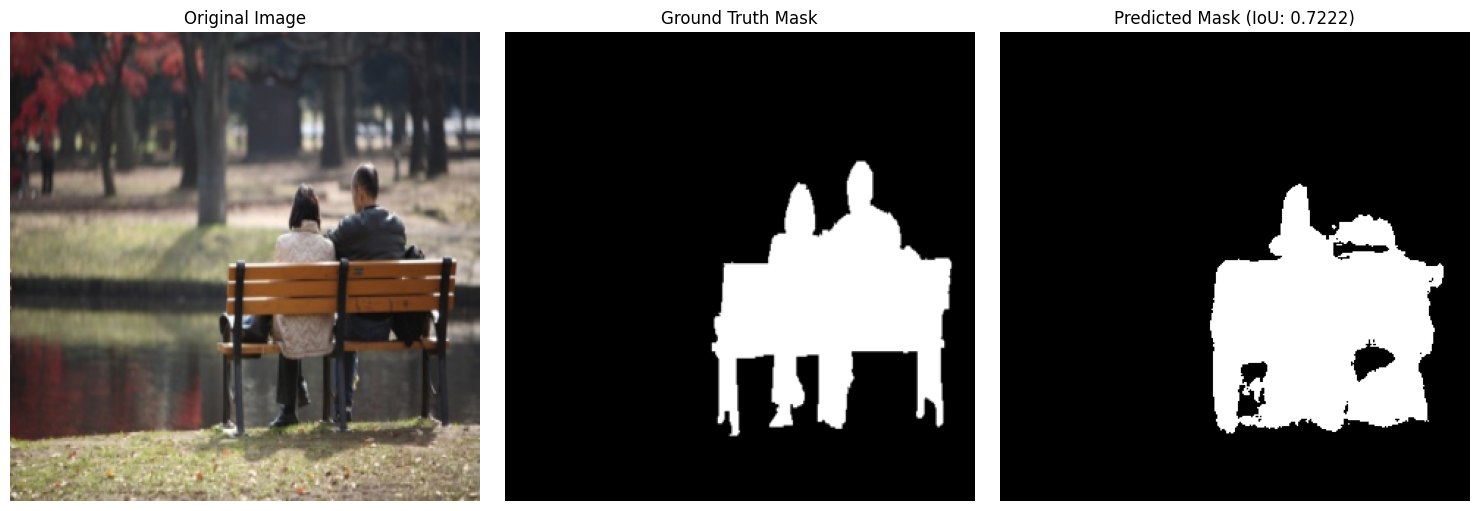

In [9]:
import random
import matplotlib.pyplot as plt

def visualize_results(model_path, dataset, device):
    # Load the trained model
    model = U2NET(in_ch=3, out_ch=1).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print("Model loaded successfully")

    # Select a random sample from the dataset
    idx = random.randint(0, len(dataset)-1)
    image, true_mask = dataset[idx]
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    # Run inference
    with torch.no_grad():
        pred_mask, _, _, _, _, _, _ = model(image)

    # Convert to numpy arrays
    image_np = image.squeeze().cpu().numpy().transpose(1, 2, 0)
    true_mask_np = true_mask.squeeze().cpu().numpy()
    pred_mask_np = pred_mask.squeeze().cpu().numpy()

    # Threshold the prediction
    pred_mask_np = (pred_mask_np > 0.5).astype(np.float32)

    # Calculate metrics
    intersection = np.logical_and(true_mask_np, pred_mask_np)
    union = np.logical_or(true_mask_np, pred_mask_np)
    iou = np.sum(intersection) / np.sum(union)

    # Create figure
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title('Original Image')
    plt.axis('off')

    # True Mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask_np, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask_np, cmap='gray')
    plt.title(f'Predicted Mask (IoU: {iou:.4f})')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Path to your saved model
model_path = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/U2-net/best_u2net_again.pth'

# Visualize results on test dataset
visualize_results(model_path, test_dataset, device)

In [10]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import io

def process_uploaded_image(model_path, uploader):
    # Load the model
    model = U2NET(in_ch=3, out_ch=1).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Get the uploaded image - NEW VERSION COMPATIBLE
    uploaded_file = next(iter(uploader.value.values()))
    image_bytes = uploaded_file['content']
    original_image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

    # Preprocess the image
    transform = transforms.Compose([
        transforms.Resize((320, 320)),
        transforms.ToTensor(),
    ])

    input_image = transform(original_image).unsqueeze(0).to(device)

    # Generate mask
    with torch.no_grad():
        pred_mask, _, _, _, _, _, _ = model(input_image)

    # Post-process mask
    mask = pred_mask.squeeze().cpu().numpy()
    mask = (mask > 0.5).astype(np.uint8) * 255  # Convert to binary mask

    # Resize mask to original image size
    mask_pil = Image.fromarray(mask).resize(original_image.size, Image.BILINEAR)
    mask_np = np.array(mask_pil) / 255.0  # Convert back to 0-1 range

    # Apply mask to original image to get salient object
    original_np = np.array(original_image)
    salient_np = original_np * mask_np[..., np.newaxis]

    # Create visualization
    plt.figure(figsize=(18, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    # Generated Mask
    plt.subplot(1, 3, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title('Generated Mask')
    plt.axis('off')

    # Salient Object
    plt.subplot(1, 3, 3)
    plt.imshow(salient_np.astype(np.uint8))
    plt.title('Salient Object Extracted')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Return the results
    return {
        'original_image': original_image,
        'mask': mask_pil,
        'salient_object': Image.fromarray(salient_np.astype(np.uint8))
    }

# Create file upload widget
uploader = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)

# Create button to process the image
process_button = widgets.Button(description="Process Image")
output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output()
        if uploader.value:
            print("Processing image...")
            results = process_uploaded_image(model_path, uploader)
            print("Done!")
        else:
            print("Please upload an image first.")

process_button.on_click(on_button_clicked)

# Display the widgets
display(widgets.VBox([uploader, process_button, output]))